In [6]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib
from matplotlib.colors import ListedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + "." + format)
    fig.clear()

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
locations = pd.read_csv(os.path.join("..", "eu_cities.csv"))
locations = locations[["city_ascii", "lng", "lat"]]
locations.rename(columns = {"city_ascii": "Client", "lng": "Longitude", "lat": "Latitude"}, inplace=True)

In [9]:
RESULTS_DIR = os.path.join("..", "results")
FILENAME = "results-"

In [10]:
df_paper = pd.DataFrame()

for experiment in ["cloud", "sat"]:
    for run in ["1", "2", "3"]:
        NAME = FILENAME + experiment + "-" + run
        files = os.listdir(os.path.join(".", RESULTS_DIR, NAME))

        df_experiment = pd.DataFrame()

        for f in files:
            if f.endswith("-history.csv"):
                client = f[2:-len(".ext4-history.csv")]
                # print(client)
                df_client = pd.read_csv(os.path.join(".", RESULTS_DIR, NAME, f))
                df_client.dropna(inplace=True)
                df_run = df_client[["Timestamp", "Type", "Name", "50%", "90%", "Total Median Response Time", "Total Average Response Time"]].copy()

                df_run["Client"] = client
                df_run["Experiment"] = experiment
                df_run["Run"] = run
                df_run["Latitude"] = locations.loc[locations["Client"] == client, "Latitude"].values[0]
                df_run["Longitude"] = locations.loc[locations["Client"] == client, "Longitude"].values[0]
                df_experiment = df_experiment.append(df_run)

        df_experiment["Timestamp"] = df_experiment["Timestamp"] - min(df_experiment["Timestamp"])
        start_time = max(df_experiment["Timestamp"]) - 1000
        df_experiment = df_experiment[ (df_experiment["Timestamp"] >  start_time) & (df_experiment["Timestamp"] < start_time+900) ]
        df_experiment["Timestamp"] = df_experiment["Timestamp"] - min(df_experiment["Timestamp"])

        df_paper = df_paper.append(df_experiment)

df_paper.head()


,Timestamp,Type,Name,50%,90%,Total Median Response Time,Total Average Response Time,Client,Experiment,Run,Latitude,Longitude
1959,0.0,GET,/,310.0,8200.0,200.0,428.974790,Coventry,cloud,1,52.4081,-1.5106
1960,0.0,POST,/,530.0,530.0,390.0,440.470588,Coventry,cloud,1,52.4081,-1.5106
1961,0.0,GET,/auth/find-friends/,270.0,520.0,170.0,309.421053,Coventry,cloud,1,52.4081,-1.5106
1962,0.0,GET,/auth/login/,0.0,0.0,44.0,44.000000,Coventry,cloud,1,52.4081,-1.5106
1963,0.0,POST,/auth/login/,0.0,0.0,430.0,728.555556,Coventry,cloud,1,52.4081,-1.5106


In [11]:
map_df = df_paper[ ((df_paper["Name"] == "/public/") & (df_paper["Type"] == "GET")) | ((df_paper["Name"] == "/") & (df_paper["Type"] == "POST")) ].groupby(["Client", "Run", "Experiment", "Type", "Name"], as_index=False).median()
# filter out Malaga, which is an outlier for some reason
# map_df = map_df[map_df["Client"] != "Malaga"]
map_df

,Client,Run,Experiment,Type,Name,Timestamp,50%,90%,Total Median Response Time,Total Average Response Time,Latitude,Longitude
0,ACoruna,1,cloud,GET,/public/,449.0,480.0,650.0,370.0,750.918803,43.3713,-8.4188
1,ACoruna,1,cloud,POST,/,449.0,0.0,0.0,740.0,1405.157895,43.3713,-8.4188
2,ACoruna,1,sat,GET,/public/,448.5,160.0,210.0,160.0,166.694805,43.3713,-8.4188
3,ACoruna,1,sat,POST,/,448.5,430.0,460.0,420.0,455.762195,43.3713,-8.4188
4,ACoruna,2,cloud,GET,/public/,449.0,580.0,700.0,410.0,712.893617,43.3713,-8.4188
...,...,...,...,...,...,...,...,...,...,...,...,...
1425,Zurich,2,sat,POST,/,449.0,470.0,550.0,550.0,668.364706,47.3786,8.5400
1426,Zurich,3,cloud,GET,/public/,449.0,390.0,530.0,290.0,630.344086,47.3786,8.5400
1427,Zurich,3,cloud,POST,/,449.0,450.0,450.0,500.0,1068.200000,47.3786,8.5400
1428,Zurich,3,sat,GET,/public/,448.5,290.0,515.0,220.0,310.168655,47.3786,8.5400


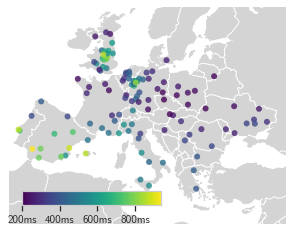

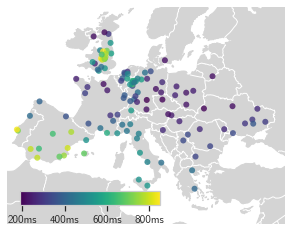

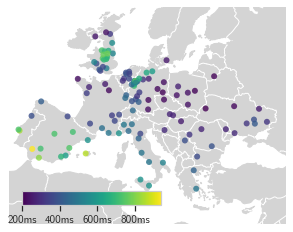

In [16]:
cmap = sns.color_palette("viridis", as_cmap=True)

def make_map(df, name):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': cartopy.crs.TransverseMercator(32)})
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))
    ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
    ax.set_extent ((-7.5, 40, 33, 59), cartopy.crs.PlateCarree())
    sns.scatterplot(ax=ax, data=df, x="Longitude", y="Latitude",hue="Total Median Response Time", palette=cmap, transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)

    norm = plt.Normalize(max(df["Total Median Response Time"]), min(df["Total Median Response Time"]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm, location='bottom', shrink=0.5, pad=-0.15, aspect=10, anchor=(0.1, 0))
    cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
    ax.axis('off')
    plt.show()
    #save_fig(ax=ax, folder="", suffix=name, format="pdf")
for run in ["1", "2", "3"]:
    make_map(map_df[ (map_df["Experiment"] == "cloud") & (map_df["Type"] == "GET") & (map_df["Run"] == run)], "cloud_get")
    make_map(map_df[ (map_df["Experiment"] == "cloud") & (map_df["Type"] == "POST")  & (map_df["Run"] == run)], "cloud_post")
    make_map(map_df[ (map_df["Experiment"] == "sat") & (map_df["Type"] == "GET")  & (map_df["Run"] == run)], "sat_get")
    make_map(map_df[ (map_df["Experiment"] == "sat") & (map_df["Type"] == "POST")  & (map_df["Run"] == run)], "sat_post")